In [1]:
import zipfile
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
from scipy.cluster.vq import kmeans,vq
import json

C:\Users\Scarlett's Laptop\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import matplotlib.cm as cm
%matplotlib inline

In [3]:
# read in data file
z = zipfile.ZipFile('201602-citibike-tripdata.zip')
df = pd.read_csv(z.open('201602-citibike-tripdata.csv'))

In [78]:
# read in station file
with open('Station.json') as station_file:
    station = json.load(station_file)
station_info = pd.DataFrame.from_dict(station['stationBeanList'])
keep_col = ['id', 'latitude', 'longitude', 'stationName', 'totalDocks']
station_info = station_info[keep_col]
station_info = station_info.set_index(['id'])

In [4]:
# parse time
df['starttime'] = df['starttime'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'))

In [27]:
# create datetime related columns
df['dayofweek'] = df.starttime.dt.dayofweek
df['day'] = df.starttime.dt.day
df['hour'] = df.starttime.dt.hour
df['cnt'] = 1

In [7]:
# create relavent index
hour_index = range(24)
timetrend_index = pd.date_range('2,1,2016', periods=696, freq='H')
station_id = list(set(df['start station id']))
id_hour_index = pd.MultiIndex.from_product([station_id, hour_index], names=['id', 'hours'])

# 1. Explore the overall trend
- Aggregate all trips by day and hour

In [9]:
grp_timetrend = df.groupby(by=['day','hour'], as_index=False)
timetrend = pd.DataFrame(grp_timetrend.cnt.sum())

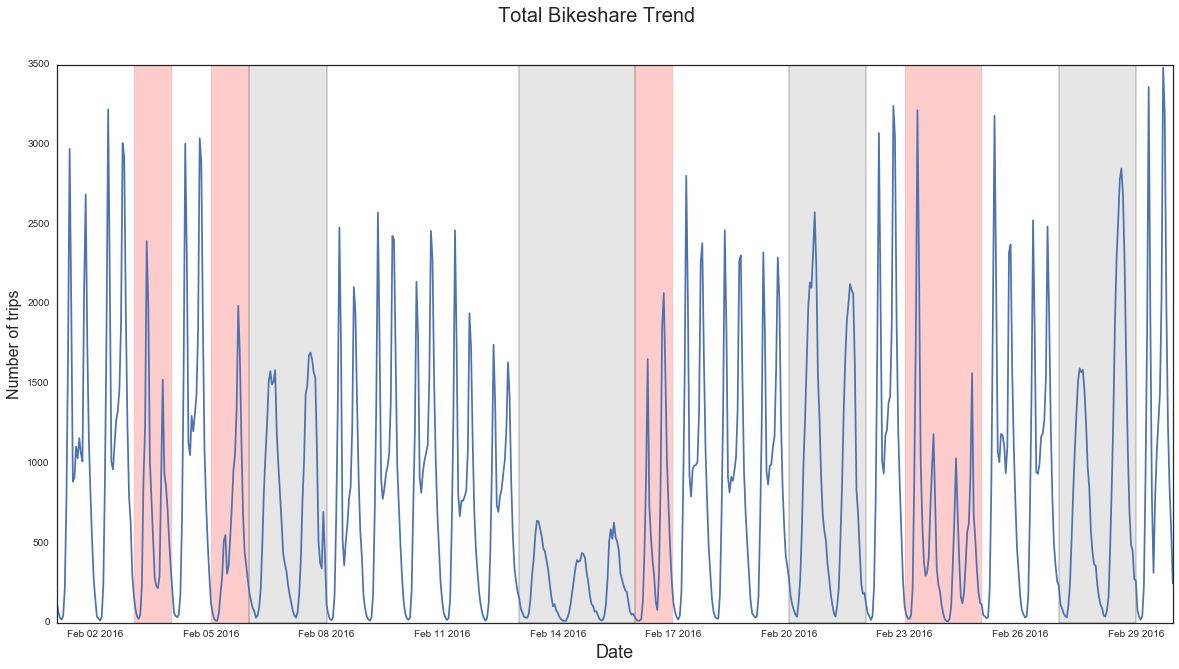

In [72]:
# plot Total bikeshare trend
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=(20,10)
plt.plot(timetrend_index, timetrend.cnt)
plt.suptitle('Total Bikeshare Trend', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of trips', fontsize=16)
# highlight weekends & holidays (15th)
plt.axvspan(xmin='2016-02-06', xmax='2016-02-08', facecolor='0.9')
plt.axvspan(xmin='2016-02-13', xmax='2016-02-16', facecolor='0.9')
plt.axvspan(xmin='2016-02-20', xmax='2016-02-22', facecolor='0.9')
plt.axvspan(xmin='2016-02-27', xmax='2016-02-29', facecolor='0.9')
# highlight bad weather days (3rd, 5th, 16th, 23rd and 24)
plt.axvspan('2016-02-03', '2016-02-04', facecolor='r', alpha=0.2)
plt.axvspan('2016-02-05', '2016-02-06', facecolor='r', alpha=0.2)
plt.axvspan('2016-02-16', '2016-02-17', facecolor='r', alpha=0.2)
plt.axvspan('2016-02-23', '2016-02-25', facecolor='r', alpha=0.2)

## Observations:
- Overall trend is cyclical and stable
- Weekday patterns are different from weekend & holiday (shaded) patterns, even when the total number of trips spikes (eg. Feb 20th and 21st, NYC Beer week), or drops (eg. Feb 3rd pm, 5th am, 16th, 23rd pm and 24th, snow and rain), the patterns remains.

### Ideally, these outliers should be taken out to form a seperate set for modeling bad-weather bikeshare predictions (or events days on weekends), in this example, for simplicity, unless noted otherwise, I keep them as they are, only seperating weekdays and weekends. Be aware this will affect the precision of the model prediction.

# 2. A closer look at the weekday and weekend pattern
- Aggregate all trips by dayofweek-hour

In [29]:
# Feb 15th is a holiday, for better modeling, change the day of week to be Sunday
df['dayofweek'] = np.where(df.day==15, 6, df.dayofweek)

In [33]:
grp_wdwend = df.groupby(by=['dayofweek','hour'])
hourly_cnt = pd.DataFrame(grp_wdwend.cnt.sum())

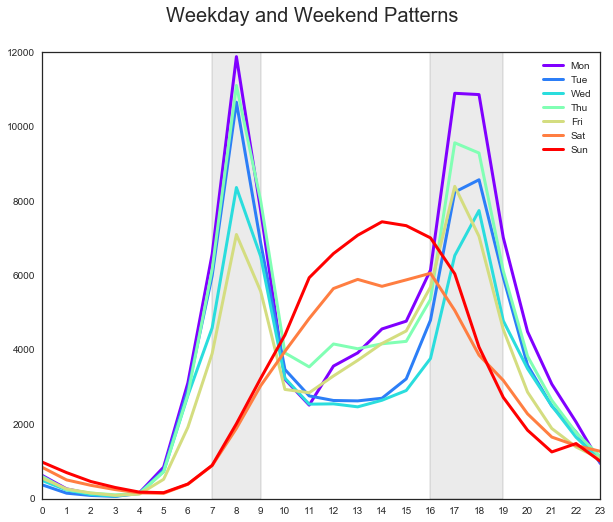

In [57]:
# plot weekday and weekend patterns
plt.rcParams['figure.figsize']=(10, 8)
plt.xticks(np.arange(0, 24, 1))
label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = iter(cm.rainbow(np.linspace(0,1,7)))
for day in range(7):
    plt.plot(hour_index, hourly_cnt.loc[day], linewidth=3, c=next(colors))
plt.axvspan(xmin=7, xmax=9, facecolor='0.85', alpha=0.5)
plt.axvspan(xmin=16, xmax=19, facecolor='0.85', alpha=0.5)   
plt.legend(label)
plt.suptitle('Weekday and Weekend Patterns', fontsize=20)

## Observations:
- For weekdays: morning peaks at 8 am and afternoon peaks at 5 to 6 pm.
- For weekends: gradual increases from 9 am to midday and then gradual decreases after 5 or 6 pm.

# 3. Station clustering
Inspired by Cathal Coffey's analysis of Capital Bikeshare http://ofdataandscience.blogspot.ch/2013/03/capital-bikeshare-time-series-clustering.html, I'd like to see if bikeshare stations on weekdays at NYC also can be clustered into 3 types, namely, morning-peak-only, morning&afternoon-peak, and afternoon-peak-only.

I use the first 3 weeks in Feburary as the training data and the last week as test data.

In [285]:
train_df = df[df.day<=20]
test_df = df[df.day>20]

In [138]:
def station_clustering(df, station_info, wday=True, normalize=True, k=3):
    """
    1. Aggregate trips taken on all weekdays (or weekends) by hour for each station
    2. Normalize by deviding the max count of each station
    3. Use Euclidean distance and K-mean to do the clustering
    Returns:
    station_clustering: DataFrame. Indexed by station id, column clust shows which cluster this station belongs to.
    station_hourly_cnt_stacked: DataFrame. Indexed by station id, columns are hours of day, values are trip counts.
    codebook: ndarray. The centroid of the clustering, returned from kmeans
    station_max: DataFrame. Indexed by station id, column is the maximum count for the corresponding station.
    """
    if wday==True:
        sub_df = df[df.dayofweek<5]
    else:
        sub_df = df[df.dayofweek>4]
    
    grp_sub_df = sub_df.groupby(['start station id', 'hour'])
    station_hourly_temp = pd.DataFrame(grp_sub_df.cnt.sum())
    
    # create full station-hour dataframe, with counts and normalized counts
    station_hourly_cnt = pd.DataFrame(data=0, index=id_hour_index, columns=['normalized_cnt'])
    station_hourly_cnt = station_hourly_cnt.join([station_hourly_temp]).fillna(0)
    station_hourly_cnt.reset_index(level=1, inplace=True, drop=True)

    # get the max counts for each station
    station_max = station_hourly_temp.max(level=0).rename(columns={'cnt':'max_cnt'})
    station_hourly_cnt = station_hourly_cnt.join([station_max])
    # calculate the normalized counts
    station_hourly_cnt['normalized_cnt'] = station_hourly_cnt.cnt / station_hourly_cnt.max_cnt.astype(float)

    # format data for clustering: each row is a station, and each column is a feature (hour of day)
    station_hourly_cnt.set_index(id_hour_index, inplace=True)
    if normalize==True:
        station_hourly_cnt_stacked = station_hourly_cnt.normalized_cnt.unstack(level=1)
    else:
        station_hourly_cnt_stacked = station_hourly_cnt.cnt.unstack(level=1)

    # clustering
    # codebook contains the k clustering centroids, ndarray
    codebook, _ = kmeans(station_hourly_cnt_stacked, k)
    # indx contains the clustering group each station is in
    indx, _ = vq(station_hourly_cnt_stacked, codebook)

    station_clustering = pd.DataFrame(indx, index=station_hourly_cnt_stacked.index, columns=['clust'])

    # join with station information
    station_clustering = station_clustering.join(station_info)
    
    return station_clustering, station_hourly_cnt_stacked, codebook, station_max

In [123]:
def plot_clusters_pattern(station_clustering, station_hourly_cnt_stacked, codebook, k=3):
    # plot station_clustering patterns
    plt.rcParams['figure.figsize']=(10, 15)
    for clust in range(k):
        df_tmp = station_clustering[station_clustering.clust==clust]
        plt.subplot(k,1,clust+1)
        plt.xticks(np.arange(0, 24, 1))
        color = ['c', 'g', 'y']
        for id in df_tmp.index:
            plt.plot(hour_index, station_hourly_cnt_stacked.loc[id], color[clust], alpha=0.1)
        plt.plot(hour_index, codebook[clust], color[clust], linewidth=3)

In [129]:
def map_station_clusters(station_clustering, label, k=3):
    # map the station locations
    plt.rcParams['figure.figsize']=(12, 15)
    color = ['c', 'g', 'y' ]    

    for cluster in range(k):
        sub = station_clustering[station_clustering.clust==cluster]
        plt.scatter(sub.longitude, sub.latitude, s=50, c=color[cluster])
    plt.legend(label, fontsize=16)

# 3.1 Weekday station clustering

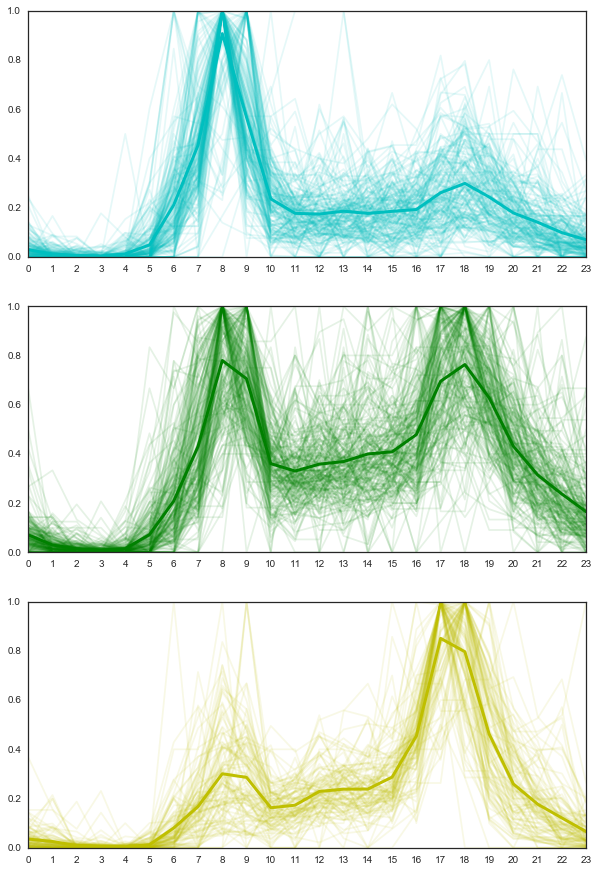

In [293]:
wday_clustering, wday_hourly_cnt_normalized, wday_codebook, station_max = station_clustering(train_df, station_info)
plot_clusters_pattern(wday_clustering, wday_hourly_cnt_normalized, wday_codebook)

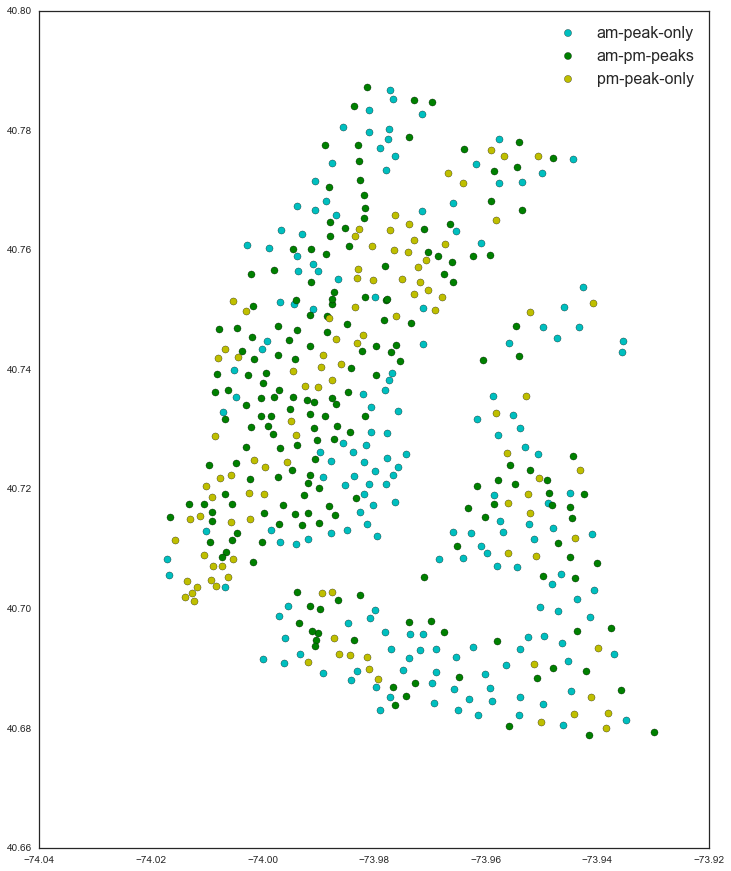

In [337]:
label = ['am-peak-only','am-pm-peaks', 'pm-peak-only']
map_station_clusters(wday_clustering, label)

# 3.2 Weekend station clustering

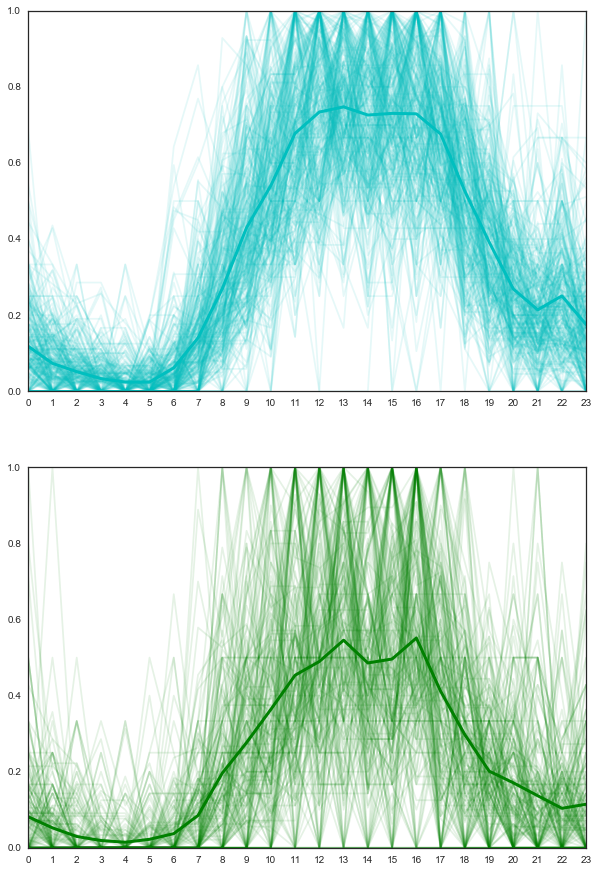

In [295]:
wend_clustering, wend_hourly_cnt_normalized, wend_codebook, station_max = station_clustering(train_df, station_info, 
                                                                                             wday=False, k=2)
plot_clusters_pattern(wend_clustering, wend_hourly_cnt_normalized, wend_codebook, k=2)

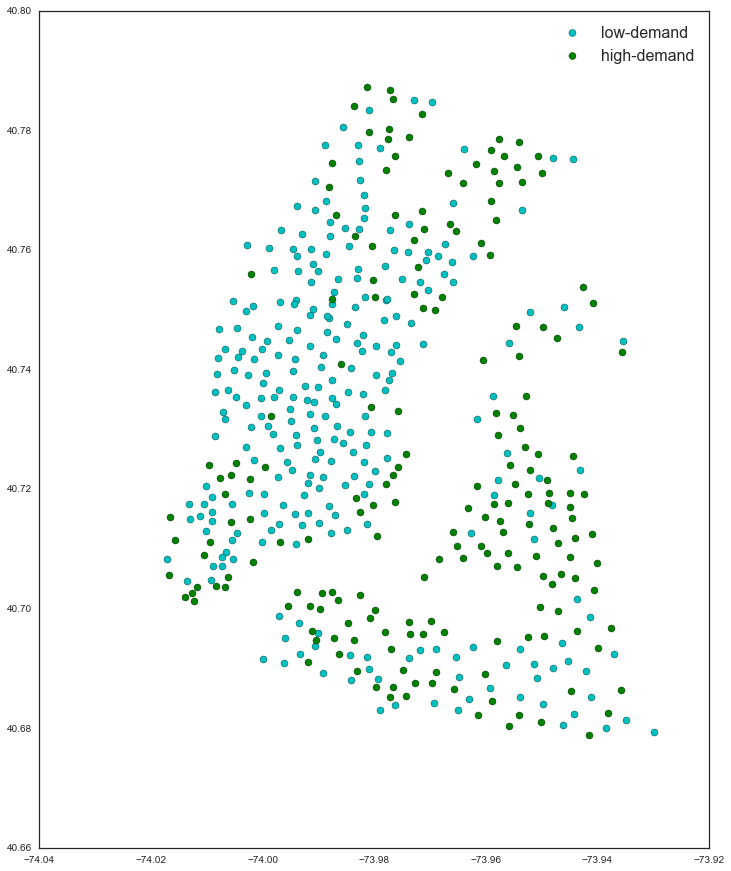

In [296]:
label = ['low-demand', 'high-demand']
map_station_clusters(wend_clustering, label, k=2)

# 4. Prediction
- For each station, predict number of trips for every hour of day, on weekdays and weekend

Use the cluster centroids in codebook (returned from function station_clustering) as baseline and extrapolate for each station by the max_cnt for that station.

# 4.1 Prediction

In [299]:
def prediction(station_clustering, codebook, k=3):
    result = pd.DataFrame()
    for clust in range(k):
        base = codebook[clust]
        id_list = wday_clustering[station_clustering.clust==clust].index.values
        for id in id_list:
            predict = base * int(station_max.loc[id])
            predict = pd.DataFrame(predict, index=hour_index, columns=[id])
            result = pd.concat([result, predict], axis=1)
    result = result.T.sort_index().round(0)
    result.index.name = 'id'
    return result

In [300]:
wday_predict = prediction(wday_clustering, wday_codebook)

In [301]:
wend_predict = prediction(wend_clustering, wend_codebook, k=2)

# 4.2 Precision check

In [307]:
train_wdays = [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 16, 17, 18, 19]
test_wdays = [22, 23, 24, 25, 26, 29]
train_wends = [6, 7, 13, 14, 15, 20]
test_wends = [21, 27, 28]

In [308]:
def precision_check(day_list, df):
    test = df[df.day.isin(day_list)]
    test_grp = test.groupby(by=['day', 'start station id', 'hour'])
    test_cnt = pd.DataFrame(test_grp.cnt.sum())
    SE = 0 # square error
    n = 0
    cur_min = float('inf')
    cur_max = 0
    for day in day_list:
        sub_df = test_cnt.loc[day]
        # get max and min for normalization
        cnt_min = sub_df.cnt.min()
        cnt_max = sub_df.cnt.max()
        sub_df = sub_df.cnt.unstack(level=1).fillna(0)
        if cnt_min < cur_min:
            cur_min = cnt_min
        if cnt_max > cur_max:
            cur_max = cnt_max
        #sub_df.index.name = 'id'
        n = n + sub_df.shape[0] * sub_df.shape[1]
        SE = SE + (wday_predict - sub_df).sum().sum()
    RMSE = np.sqrt(SE/n) / (cnt_max - cnt_min)
    return RMSE

In [309]:
train_wday_RMSE = precision_check(train_wdays, train_df)
test_wday_RMSE = precision_check(test_wdays, test_df)
train_wend_RMSE = precision_check(train_wends, train_df)
test_wend_RMSE = precision_check(test_wends, test_df)

In [311]:
print "train_wday_RMSE: ", train_wday_RMSE
print "test_wday_RMSE: ", test_wday_RMSE
print "train_wend_RMSE: ", train_wend_RMSE
print "test_wend_RMSE: ", test_wend_RMSE

train_wday_RMSE:  0.0451958902925
test_wday_RMSE:  0.0188813838632
train_wend_RMSE:  0.0563276244484
test_wend_RMSE:  0.0334950727999


### For each group (weekdays and weekends), the test RSME is better than the training RSME, indicating this model is successful.

# 5. User behavior exploration

## 5.1 Trip duration by user type

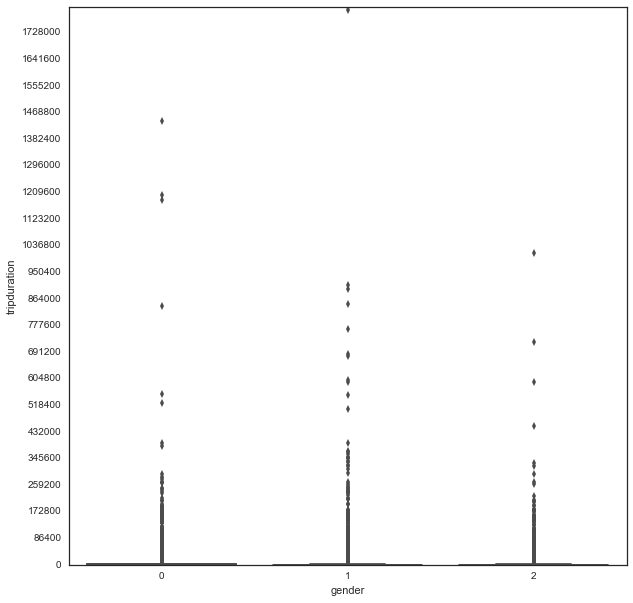

In [312]:
plt.rcParams['figure.figsize']=(10,10)
plt.yticks(np.arange(0, max(df.tripduration), 86400))
sns.boxplot(x="gender", y="tripduration", data=df)

In [313]:
df.groupby(['gender']).tripduration.quantile([.25, .5, .75])

gender      
0       0.25     740.0
        0.50    1229.0
        0.75    1777.0
1       0.25     316.0
        0.50     493.0
        0.75     784.0
2       0.25     366.0
        0.50     571.0
        0.75     906.0
dtype: float64

## Observations:
- There are people who keep the bike for a few days, even as long as more than 20 days. Based on citibikenyc website, these are regarded errors.
-  Non-subscribers tend to take longer trips than subscribers: 75% trips are done in half an hour VS 15 minutes.

In [314]:
# Let's focus on trips that's within 1 hours (<= 3600 s)
df2 = df[df.tripduration<=3600]

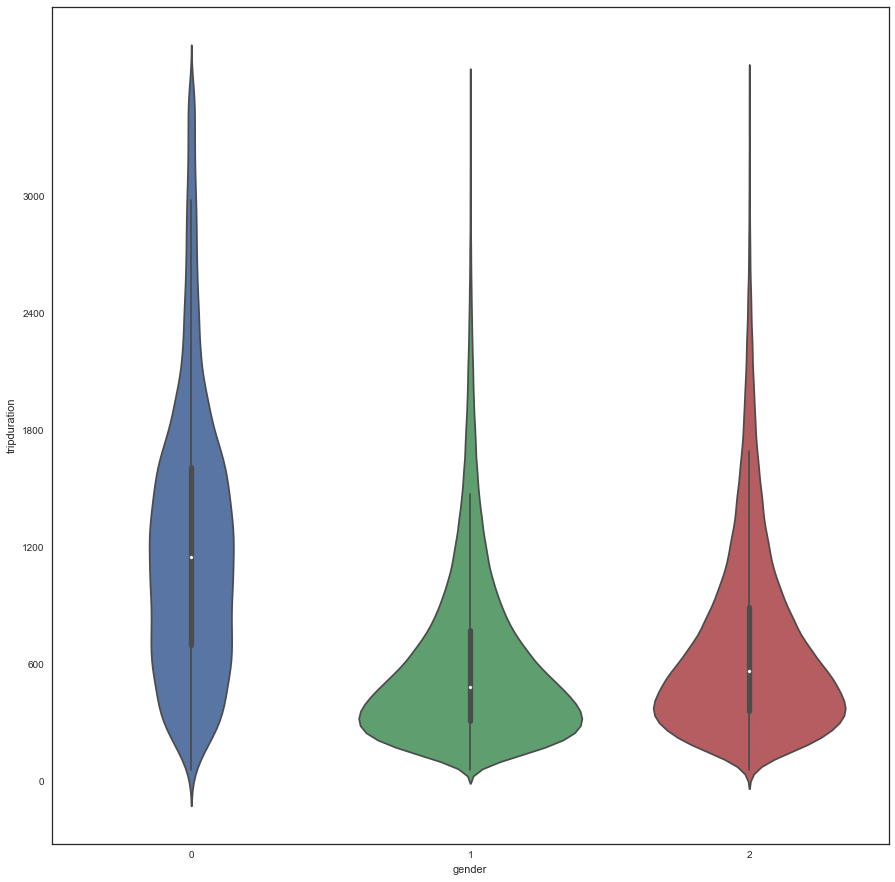

In [322]:
plt.yticks(np.arange(0, 3600, 600))
sns.violinplot(x="gender", y="tripduration", data=df2)

## Observation:
- For subscribers, most trips are done within 10 mintues, whereas non-subscribers make roughly the same amount of trips that last for 10 - 20 minutes.
- Little gender difference.

## 5.2 Trip time by user type

In [316]:
grp = df2.groupby(by=['dayofweek','hour','usertype'], as_index=False)
ts = pd.DataFrame(grp.cnt.sum())
ts_subscriber = ts[ts.usertype=='Subscriber']
ts_customer = ts[ts.usertype=='Customer']

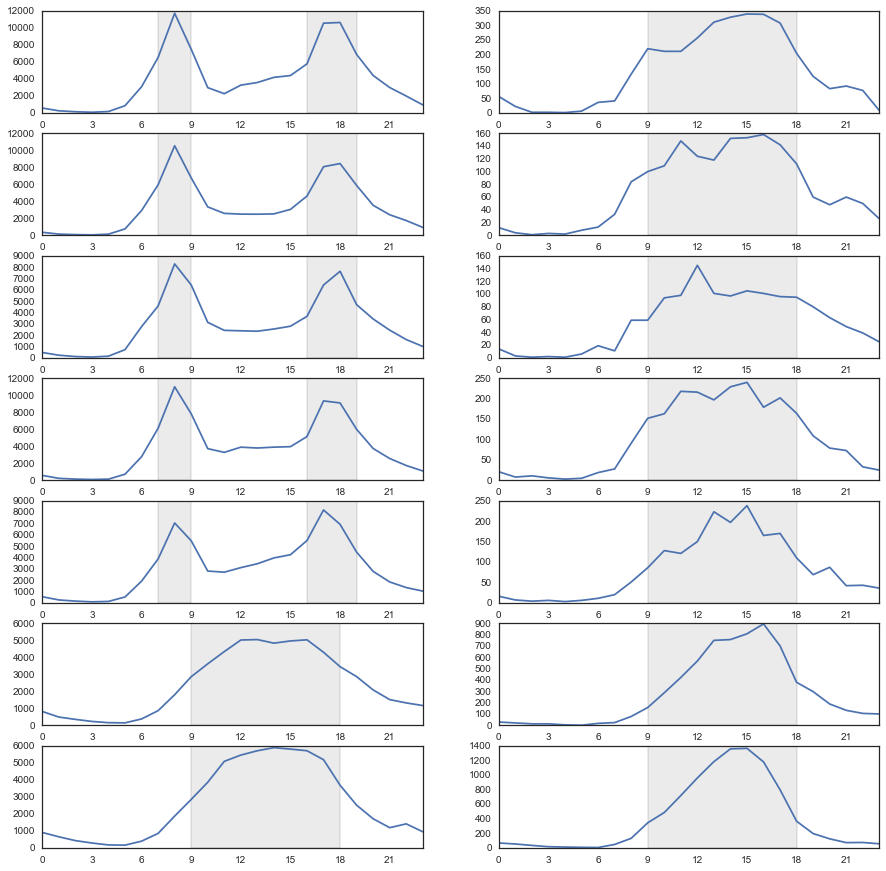

In [320]:
plt.rcParams['figure.figsize']=(15,15)
image = 1
for day in range(7):
    df_sub = ts_subscriber[ts_subscriber.dayofweek==day]
    df_cus = ts_customer[ts_customer.dayofweek==day]
    ax = plt.subplot(7,2,image)
    plt.xticks(np.arange(0, 24, 3))
    plt.plot(hour_index, df_sub.cnt)
    if day < 5:
        plt.axvspan(xmin=7, xmax=9, facecolor='0.85', alpha=0.5)
        plt.axvspan(xmin=16, xmax=19, facecolor='0.85', alpha=0.5)   
    else:
        plt.axvspan(xmin=9, xmax=18, facecolor='0.85', alpha=0.5)    
    image = image + 1
    
    ax = plt.subplot(7,2,image)
    plt.xticks(np.arange(0, 24, 3))
    plt.plot(hour_index, df_cus.cnt)
    plt.axvspan(xmin=9, xmax=18, facecolor='0.85', alpha=0.5)
    image = image + 1

## Observations: 
- During the weekdays, subscribers use bikes for daily commute. 
- Non-subscribers' weekday pattern is similar to weekends.
- Non-subscribers have more activities during weekends than during the week.